In [19]:
import lightgbm as lgb  # 模型
import pandas as pd  # 数据处理包
import numpy as np  # 数据处理包
from sklearn import metrics  # 混淆矩阵
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split  # 分层五折验证包、寻找最优参函数、切分数据
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix  # 准确率、roc计算、auc计算、混淆矩阵
import matplotlib.pyplot as plt  # 图形处理包
import itertools  # 处理混淆矩阵
import gc  # 处理缓存，有兴趣的可以搜搜怎么使用
import warnings  # 忽略普通警告，不打印太多东西
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']  # 让图形可以显示中文
plt.rcParams['axes.unicode_minus']=False


def preprocessing(df_train, df_pre, feats_list=0, label='label', id_1='id'):
    """
    功能:将训练集和预测集做处理，并输出
    df_train: 未处理过的训练集（df型/有label）
    df_pre: 未处理过的预测集（df型/有label）
    feats_list: 特征表，默认使用全部特征，可传入list
    label: 标签，判断0/1
    id: id
    return: 
        dt_train: 处理过的训练集
        df_pre: 处理过的预测集
        X: 训练数据X（df型/无label）
        y: 训练数据y（df型/label）
        X_test_v1: 预测数据X（df型/无label）
        y_test_v1: 预测数据y（df型/label）
    """
    print("=============开始处理数据集===============")
    print("未处理训练集数据大小：", df_train.shape)
    print("未处理预测集数据大小：", df_pre.shape)
    # 和if不同，try的代码即使错了，也不会报错中断代码
    try:
        df_train = df_train.dropna(subset=['A字段']).reset_index(drop=True)  # 删掉指定列为null值的行
        df_train = df_train[df_train['B字段'] >= 0].reset_index(drop=True)  # 去掉指定列非数值的行
        df_pre = df_pre.dropna(subset=['A字段']).reset_index(drop=True)  # 预测集做同样的操作
        df_pre = df_pre[df_pre['B字段'] >= 0].reset_index(drop=True)
    except KeyError:
        print("数据集里没有相应字段")
        
    print("处理后训练集数据大小：", df_train.shape)
    print("处理后预测集数据大小：", df_pre.shape)    
    print("=============数据集处理完成===============")
    
    print("==============开始切分数据=================")
    if feats_list==0:
        print("使用全部特征")
        X = df_train[df_train.columns.drop([id_1, label])]
        X_test_v1 = df_pre[df_pre.columns.drop([id_1, label])]
    elif type(feats_list) == list:
        print("使用列表特征，长度为：", len(feats_list))
        X = df_train[feats_list]
        X_test_v1 = df_pre[feats_list]
    else:
        print("feats_list输入有误")
    y = df_train[label]
    y_test_v1 = df_pre[label]
    X = X.fillna(0)  # null值补0，这是经过模型做出来的最好处理方式
    X_test_v1 = X_test_v1.fillna(0)
    print("训练集正负样本情况：")
    print(pd.value_counts(df_train[label]))
    print("预测集正负样本情况：")
    print(pd.value_counts(df_pre[label]))
    print("==============数据切分完成=================")
    return df_train, df_pre, X, y, X_test_v1, y_test_v1


def train_5_cross(df_pre, X,y, X_test_v1,y_test_v1, thresholds=0.45, id_1='id', csv_name=0):
    """
    功能: 五折训练并输出名单
    df_pre：原始预测数据
    X: 训练数据X（无标签/df型）
    y: 训练数据y（标签/df型）
    X_test_v1: 预测数据X（无标签/df型）
    y_test_v1: 预测数据y（无标签/df型）
    thresholds: 阈值选择，默认0.45高精确率
    csv_name: 保存csv的名称，默认不保存
    returen:
        模型，客户名单及情况
    """
    vali_auc_num=0  # 验证集AUC
    vali_recall_num=0  # 验证集召回率
    vali_precision_num=0  # 验证集精确率
    test_auc_num=0  # 预测集AUC
    test_recall_num=0  # 预测集召回率
    test_precision_num=0  # 预测集精确率
    y_pred_input = np.zeros(len(X_test_v1))  # 相应大小的零矩阵
    print("=============开始训练================")
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)  # 分层采样, n_splits为几折
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("第 {} 次训练...".format(fold_+1))
        train_x, trai_y = X.loc[trn_idx], y.loc[trn_idx]
        vali_x, vali_y = X.loc[val_idx], y.loc[val_idx]
        
        # 以下为调过参的lgb模型
        clf = lgb.LGBMClassifier(max_depth=20, min_data_in_bin=5, max_bin=200,
                                min_child_samples=90, num_leaves=20, n_estimators=20000,
                                objective='binary', boosting_type='gbdt', learning_rate=0.02,
                                lambda_l2=5)
        clf.fit(train_x, trai_y, eval_set=[(train_x, trai_y), (vali_x, vali_y)], verbose=0,
               early_stopping_rounds=100, eval_metric='f1')
        
        # 不懂的去GitHub看搜LightGBM的参数解释
        
        # ===============验证集AUC操作===================
        y_prb = clf.predict_proba(vali_x)[:,1]  # 获取预测概率
        # fpr:在实际为正的样本中，被正确判断为正的比例。tpr:在实际为负的样本中，被正确判断为负的比例。thres为阈值
        fpr, tpr, thres = roc_curve(vali_y, y_prb)
        vali_roc_auc = auc(fpr, tpr)  # 获取验证集auc
        vali_auc_num += vali_roc_auc  # 将本次auc加入总值里
        print("vali auc = {0:.4}".format(vali_roc_auc))  # 本次auc的值
        # ===============预测集AUC操作===================
        y_prb_test = clf.predict_proba(X_test_v1)[:,1]  # 获取预测概率
        fpr, tpr, thres = roc_curve(y_test_v1, y_prb_test)
        test_roc_auc = auc(fpr, tpr)
        test_auc_num += test_roc_auc
        print("test auc = {0:.4}".format(test_roc_auc))
        
        # ===============验证metric操作===================
        y_pre_proba = clf.predict_proba(vali_x.values)
        y_predictions = y_pre_proba[:, 1]>thresholds  # 取阈值多少以上的为True
        cnf_matrix = confusion_matrix(vali_y, y_predictions)  # 建立矩阵
        np.set_printoptions(precision=2)  # 控制在两位数
        vali_recall = '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))  # 召回率
        vali_precision = '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))  # 精确率
        print("vali_metric: ", vali_recall, vali_precision)
        vali_recall_num += float(vali_recall)  # 将本次召回率加入总值里
        vali_precision_num += float(vali_precision)  # 将本次精确率加入总值里
        # ===============预测metric操作===================
        y_pre_proba_test = clf.predict_proba(X_test_v1.values)
        y_predictions_test = y_pre_proba_test[:, 1]>thresholds  # 取阈值多少以上的为True
        cnf_matrix_test = confusion_matrix(y_test_v1, y_predictions_test)  # 建立矩阵
        np.set_printoptions(precision=2)  # 控制在两位数
        test_recall = '{0:.3f}'.format(cnf_matrix_test[1,1]/(cnf_matrix_test[1,0]+cnf_matrix_test[1,1]))  # 召回率
        test_precision = '{0:.3f}'.format(cnf_matrix_test[1,1]/(cnf_matrix_test[0,1]+cnf_matrix_test[1,1]))  # 精确率
        print("test_metric: ", test_recall, test_precision)
        test_recall_num += float(test_recall)  # 将本次召回率加入总值里
        test_precision_num += float(test_precision)  # 将本次精确率加入总值里
        y_pred_input += y_pre_proba_test[:, 1]  # 将每次的预测的结果写入数组中
        
    print("5折泛化，验证集AUC：{0:.3f}".format(vali_auc_num/5))  # 前面是做了5次相加，所以这次要除以5
    print("5折泛化，预测集AUC：{0:.3f}".format(test_auc_num/5))
    
    print("5折泛化，验证集recall：{0:.3f}".format(vali_recall_num/5))
    print("5折泛化，验证集precision：{0:.3f}".format(vali_recall_num/5))
    
    print("5折泛化，预测集recall：{0:.3f}".format(test_recall_num/5))
    print("5折泛化，预测集precision：{0:.3f}".format(test_recall_num/5))
    
    print("================开始输出名单==================")
    y_pred_input_end = y_pred_input / 5  # 前面是做了5次相加，所以这次要除以5
    y_pred_input_precision = y_pred_input_end > thresholds  # 获取高精确率的标签
    submission = pd.DataFrame({"id": df_pre[id_1],
                              "概率": y_pred_input_end,
                              "高精确": y_pred_input_precision})
    if csv_name != 0:
        submission.to_csv("%s预测名单.csv" % csv_name, index=False)  # 保存
    print("================输出名单名单==================")
    print(submission.head(5))
    return clf
    
    
def auc_plot(y, y_prob, thres=0.5, png_savename=0):
    """
    why: 能够知道模型的效果，AUC越高，则模型分辨正负样本的能力越好。
    功能: 画出AUC图
    y: 真实结果（标签/df型）
    y_prob：预测概率（浮点数）
    png_savename: 保存图片的名字，默认不保存
    return: AUC图
    """
    y_prediction = y_prob > thres  # 输出预测的结果
    fpr, tpr, thres = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)  # 计算AUC
    # 画出AUC
    plt.plot(fpr, tpr, label="AUC = {0:.4f}".format(roc_auc), ms=100)
    plt.title("ROC曲线", fontsize=20)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('误判率', fontsize=15)
    plt.ylabel('命中率', fontsize=15)
    if png_savename != 0:
        plt.savefig("%s_AUC图.png" % png_savename, dpi=300)  # 保存AUC图, dpi清晰度，越大越清晰
    plt.show()
    print("Accuracy: {0:.2f}".format(accuracy_score(y, y_prediction)))  # 准确率
    
    
def metrics_ks(y, y_predicted):
    """
    功能: 计算模型性能指标：ks， 找到最佳threshold值
    y: 数据y（标签/df型）
    y_predicted: 概率值， 公式为：= clf.predict_proba(X)[:, 1]
    return:
        ks值
        thres_ks值
    """
    fpr, tpr, thres = metrics.roc_curve(y, y_predicted, pos_label=1)
    ks = abs(fpr - tpr).max()  # abs:返回数字绝对值的函数
    tmp = abs(fpr - tpr)
    index_ks = np.where(tmp=ks)  # np.where: 返回符合条件的下标函数
    thres_ks = thres[index_ks]
    return ks, thres_ks
    

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    混淆矩阵画图函数
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment='center', color='white' if cm[i, j]> thresh else 'black')
        plt.tight_layout()
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        
        
def metrics_plot(y, y_prob, thres=0.45, png_savename=0):
    """
    why: 能选择是召回率高，还是精确率高，也能从一定层面看出模型的效果。
    功能: 画出混淆矩阵图
    y: 真实值y（标签/df型）
    y_prob：预测概率
    thres: 阈值，多少以上为预测正确
    png_savename: 保存图片的名字，默认不保存
    return: 输出混淆矩阵图
    """
    y_prediction = y_prob > thres  # 多少以上的概率判定为正
    cnf_matrix = confusion_matrix(y, y_prediction)  # 形成混淆矩阵
    np.set_printoptions(precision=2)  # 设置浮点精度
    vali_recall = '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))  # 召回率
    vali_precision = '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))  # 精确率
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='召回率=%s%% \n 精确率=%s%%' %('{0:.1f}'.format(float(vali_recall)*100),
                                                                                         '{0:.1f}'.format(float(vali_precision)*100)))
    if png_savename!=0:
        plt.savefig("%s_混淆矩阵.png" % png_savename,dpi=300)  # 保存混淆矩阵图
        

def importance_plt(X, clf, png_savename=0):
    """
    why: 能看出哪个特征更重要，继而对特征做相关衍生，也可以讲特征使用次数为0的特征去掉，防止冗余
    功能:打印特征重要图
    X: 数据X（无标签/df型）
    clf: 已训练过的最佳lgb模型
    png_savename: 保存图片的名字，默认不保存
    return: 打印出特征重要性图
    """
    feats_list = X.columns.values  # 获取全部特征
    feats_importance = clf.feature_importances_  # 获取特征使用次数
    sorted_idx = np.argsort(feats_importance)
    
    plt.figure(figsize=(10, 55))
    # 下面是画图操作
    plt.barh(range(len(sorted_idx)), feats_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), feats_list[sorted_idx])
    plt.xlabel("Importance")
    plt.title("Feature importances")
    if png_savename:
        plt.savefig("特征重要性.png", dpi=500, bbox_inches='tight')  # 由于特征过多图片过大，所以需要这些处理才能让图片全部保存下来
    plt.show()
    
    
def just_num_leaves(X, y, start_num=10, end_num=101, step=10):
    """
    功能: 找到最优num_leaves参数，以此类推找出全部的最优参
    X: 数据X（无标签/df型）
    y: 数据y（标签/df型）
    start_num: 开始值
    end_num: 最大值
    step: 步数
    return: 最佳num_leaves
    """
    param_dic = {'num_leaves': range(start_num, end_num, step)}
    gscv = GridSearchCV(estimator=lgb.LGBMClassifier(max_depth=20, min_data_in_bin=5, max_bin=200,
                                                     min_child_samples=90, n_estimators=20000,
                                                     objective='binary', boosting_type='gbdt', learning_rate=0.02,
                                                     lambda_l2=5),
                       param_grid=param_dic, scoring='f1', cv=5)
    gscv.fit(X, y)
    print("best_params:{0}".format(gscv.best_params_))
    print("best_score:{0}".format(gscv.best_score_))
    
    
def train_2_cross(df_pre, X,y, X_test_v1,y_test_v1, thresholds=0.45, id_1='id', csv_name=0):
    """
    功能:切分一次训练，输出名单
    X: 训练数据X（无标签/df型）
    y: 训练数据y（标签/df型）
    X_test_v1: 预测数据X（无标签/df型）
    y_test_v1: 预测数据y（无标签/df型）
    thresholds: 阈值选择，默认0.45高精确率
    csv_name: 保存csv的名称，默认不保存
    returen:
        客户名单及情况
        clf: 已训练好的模型
    """
    y_pred_input = np.zeros(len(X_test_v1))  # 相应大小的零矩阵
    train_x, vali_x, train_y,vali_y = train_test_split(X, y, test_size=0.33, random_state=1234)
    clf = lgb.LGBMClassifier(max_depth=20, min_data_in_bin=5, max_bin=200,
                            min_child_samples=90, num_leaves=20, n_estimators=20000,
                            objective='binary', boosting_type='gbdt', learning_rate=0.02,
                            lambda_l2=5)
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (vali_x, vali_y)], verbose=0,
           early_stopping_rounds=100, eval_metric='f1')
    # 这里的参数不懂的去GitHub搜LightGBM的参数解释

    # ===============验证集AUC操作===================
    y_prb = clf.predict_proba(vali_x)[:,1]  # 获取预测概率
    # fpr:在实际为正的样本中，被正确判断为正的比例。tpr:在实际为负的样本中，被正确判断为负的比例。thres为阈值
    fpr, tpr, thres = roc_curve(vali_y, y_prb)
    vali_roc_auc = auc(fpr, tpr)  # 获取验证集auc
    print("vali auc = {0:.4}".format(vali_roc_auc))  # 本次auc的值
    # ===============预测集AUC操作===================
    y_prb_test = clf.predict_proba(X_test_v1)[:,1]  # 获取预测概率
    fpr, tpr, thres = roc_curve(y_test_v1, y_prb_test)
    test_roc_auc = auc(fpr, tpr)
    print("test auc = {0:.4}".format(test_roc_auc))
    
    # ===============训练metric操作===================
    y_pre_proba = clf.predict_proba(vali_x.values)
    y_predictions = y_pre_proba[:, 1]>thresholds  # 取阈值多少以上的为True
    cnf_matrix = confusion_matrix(vali_y, y_predictions)  # 建立矩阵
    np.set_printoptions(precision=2)  # 控制在两位数
    vali_recall = '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))  # 召回率
    vali_precision = '{0:.3f}'.format(cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))  # 精确率
    print("vali_metric: ", vali_recall, vali_precision)
    # ===============预测metric操作===================
    y_pre_proba_test = clf.predict_proba(X_test_v1.values)
    y_predictions_test = y_pre_proba_test[:, 1]>thresholds  # 取阈值多少以上的为True
    cnf_matrix_test = confusion_matrix(y_test_v1, y_predictions_test)  # 建立矩阵
    np.set_printoptions(precision=2)  # 控制在两位数
    test_recall = '{0:.3f}'.format(cnf_matrix_test[1,1]/(cnf_matrix_test[1,0]+cnf_matrix_test[1,1]))  # 召回率
    test_precision = '{0:.3f}'.format(cnf_matrix_test[1,1]/(cnf_matrix_test[0,1]+cnf_matrix_test[1,1]))  # 精确率
    print("test_metric: ", test_recall, test_precision)

    print("================开始输出名单==================")
    y_pred_input_precision = y_pre_proba_test[:, 1] > thresholds  # 获取高精确率的标签
    submission = pd.DataFrame({"id": df_pre[id_1],
                              "概率": y_pre_proba_test[:, 1],
                              "高精确": y_pred_input_precision})
    if csv_name != 0:
        submission.to_csv("%s预测名单.csv" % csv_name, index=False)  # 保存
    print("================输出名单名单==================")
    print(submission.head(5))
    return clf

In [3]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/train.csv')  # 这里读train，因为有label比较对错，可以改成test并修改相应的数据处理和训练函数

In [4]:
train_data.head()

id  label      date  f1  f2  \
0  cb3dff566c2e804ee5842a50d1641f934e2a3b5f630c4d...      0  20171026   0   1   
1  d59c75a60aaf0ad51d05624de6a78c32ab87e07a0847bc...      0  20170930   0   0   
2  e73af2a7c4d2991c898010c2c8fd00b3d81d3f8f6a7fca...      0  20171028   1   0   
3  aebb59c3288fea434e60c94d732abff99ac8e1f2c503fa...      0  20171021   1   0   
4  5d2d91c0023379976e97fbce2f30217fff35690c681305...      0  20170907   1   0   

   f3  f4        f5  f6  f7  ...   f288   f289   f290   f291   f292   f293  \
0   1   0  100805.0   1   4  ...    2.0    1.0    1.0    1.0    2.0    1.0   
1   1   1  100804.0   1   3  ...    2.0    3.0    4.0    1.0    1.0    1.0   
2   2   0       NaN   2   2  ...    NaN    NaN    NaN    NaN    NaN    NaN   
3   1   0       NaN   1   5  ...    NaN    NaN    NaN    NaN    NaN    NaN   
4   1   0  100805.0   0   5  ...  301.0  301.0  302.0  126.0  274.0  250.0   

    f294   f295   f296   f297  
0    1.0    1.0    1.0    2.0  
1    2.0    2.0    1.0    1.0  
2    NaN    NaN    NaN    NaN  
3    NaN    NaN    NaN    NaN  
4  251.0  251.0  109.0  227.0  

[5 rows x 300 columns]

In [5]:
test_data.head()

id  label      date  f1  f2  \
0  cb3dff566c2e804ee5842a50d1641f934e2a3b5f630c4d...      0  20171026   0   1   
1  d59c75a60aaf0ad51d05624de6a78c32ab87e07a0847bc...      0  20170930   0   0   
2  e73af2a7c4d2991c898010c2c8fd00b3d81d3f8f6a7fca...      0  20171028   1   0   
3  aebb59c3288fea434e60c94d732abff99ac8e1f2c503fa...      0  20171021   1   0   
4  5d2d91c0023379976e97fbce2f30217fff35690c681305...      0  20170907   1   0   

   f3  f4        f5  f6  f7  ...   f288   f289   f290   f291   f292   f293  \
0   1   0  100805.0   1   4  ...    2.0    1.0    1.0    1.0    2.0    1.0   
1   1   1  100804.0   1   3  ...    2.0    3.0    4.0    1.0    1.0    1.0   
2   2   0       NaN   2   2  ...    NaN    NaN    NaN    NaN    NaN    NaN   
3   1   0       NaN   1   5  ...    NaN    NaN    NaN    NaN    NaN    NaN   
4   1   0  100805.0   0   5  ...  301.0  301.0  302.0  126.0  274.0  250.0   

    f294   f295   f296   f297  
0    1.0    1.0    1.0    2.0  
1    2.0    2.0    1.0    1.0  
2    NaN    NaN    NaN    NaN  
3    NaN    NaN    NaN    NaN  
4  251.0  251.0  109.0  227.0  

[5 rows x 300 columns]

In [6]:
df_train, df_pre, X, y, X_test_v1, y_test_v1 = preprocessing(train_data, test_data)

=============开始处理数据集===============
未处理训练集数据大小： (100000, 300)
未处理预测集数据大小： (100000, 300)
数据集里没有相应字段
处理后训练集数据大小： (100000, 300)
处理后预测集数据大小： (100000, 300)
=============数据集处理完成===============
==============开始切分数据=================
使用全部特征
训练集正负样本情况：
0    98145
1     1855
Name: label, dtype: int64
预测集正负样本情况：
0    98145
1     1855
Name: label, dtype: int64
==============数据切分完成=================


In [12]:
clf = train_5_cross(df_pre,X, y, X_test_v1, y_test_v1)

=============开始训练================
第 1 次训练...
vali auc = 0.9787
test auc = 0.9942
vali_metric:  0.437 0.645
test_metric:  0.700 0.861
第 2 次训练...
vali auc = 0.98
test auc = 0.9939
vali_metric:  0.447 0.654
test_metric:  0.678 0.850
第 3 次训练...
vali auc = 0.9784
test auc = 0.9936
vali_metric:  0.396 0.590
test_metric:  0.662 0.842
第 4 次训练...
vali auc = 0.9761
test auc = 0.993
vali_metric:  0.407 0.583
test_metric:  0.653 0.833
第 5 次训练...
vali auc = 0.9811
test auc = 0.9932
vali_metric:  0.407 0.592
test_metric:  0.635 0.824
5折泛化，验证集AUC：0.979
5折泛化，预测集AUC：0.994
5折泛化，验证集recall：0.419
5折泛化，验证集precision：0.419
5折泛化，预测集recall：0.666
5折泛化，预测集precision：0.666
================开始输出名单==================
================输出名单名单==================
                                                  id        概率    高精确
0  cb3dff566c2e804ee5842a50d1641f934e2a3b5f630c4d...  0.000410  False
1  d59c75a60aaf0ad51d05624de6a78c32ab87e07a0847bc...  0.000523  False
2  e73af2a7c4d2991c898010c2c8fd00b3d81d3f8f6a7fca...  0.

In [14]:
clf = train_2_cross(df_pre,X,y, X_test_v1,y_test_v1)

vali auc = 0.9793
test auc = 0.9912
vali_metric:  0.421 0.591
test_metric:  0.606 0.802
================开始输出名单==================
================输出名单名单==================
                                                  id        概率    高精确
0  cb3dff566c2e804ee5842a50d1641f934e2a3b5f630c4d...  0.000526  False
1  d59c75a60aaf0ad51d05624de6a78c32ab87e07a0847bc...  0.000889  False
2  e73af2a7c4d2991c898010c2c8fd00b3d81d3f8f6a7fca...  0.004408  False
3  aebb59c3288fea434e60c94d732abff99ac8e1f2c503fa...  0.006726  False
4  5d2d91c0023379976e97fbce2f30217fff35690c681305...  0.000456  False


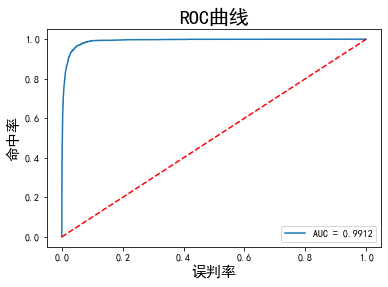

Accuracy: 0.99


In [15]:
prob = clf.predict_proba(X)[:, 1]  #获取概率
auc_plot(y,prob)

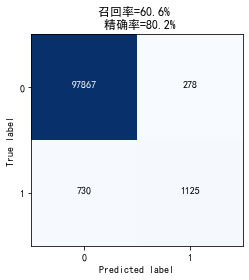

In [17]:
metrics_plot(y, prob, thres=0.45)